In [1]:
import torch
import torch.nn.functional as F
with open('../chinese_name.txt') as f:
    names = f.read().splitlines()

In [2]:
words = [i.split('\t')[2] for i in names[1:]]

In [3]:
# Create index representation of word/char
chars = sorted(list(set(''.join(words)+'.')))
idx2char = {idx:c for idx,c in enumerate(chars)}
char2idx = {c:idx for idx,c in enumerate(chars)}

In [4]:
# Build training dataset
block = 2
X, Y = [], []
for i in words:
    # print(i)
    context = [0] * block
    for j in (i+'.'):
        # x_word = ''.join([idx2char[k] for k in context])
        # print(f'{x_word} ------> {j}')
        X.append(context)
        Y.append(char2idx[j])
        context = context[1:] + [char2idx[j]]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([13170646, 2]), torch.int64, torch.Size([13170646]), torch.int64)

In [7]:
# manually make a forward pass to get loss
emb_hidden = 2
hidden_size = 50
C = torch.randn((len(char2idx), emb_hidden),requires_grad=True)
# emb can use onehot + @ or can use index C[X]
emb = F.one_hot(X,len(char2idx)).float() @ C
emb.shape

W1 = torch.randn((emb_hidden*block, hidden_size),requires_grad=True) * 0.1
b1 = torch.randn(hidden_size,requires_grad=True) * 0.1
Z1 = emb.view(-1, emb_hidden*block) @ W1 + b1
A1 = Z1.tanh()

W2 = torch.randn((hidden_size, len(char2idx)),requires_grad=True) * 0.1
b2 = torch.randn(len(char2idx),requires_grad=True) * 0.1
A2 = A1 @ W2 + b2

prob = A2.exp() / A2.exp().sum(dim=1,keepdim=True)
loss = -prob[torch.arange(len(X)),Y].log().mean()
print(f'{loss=:.4f}')

: 

In [6]:
# Again, group all parameters here and count total number of parameters
g = torch.Generator().manual_seed(1234)
emb_hidden = 128
hiddensize = 256

C = torch.randn((len(char2idx), emb_hidden),generator=g)
W1 = torch.randn((emb_hidden*block, hiddensize),generator=g) * 0.01
b1 = torch.randn(hiddensize,generator=g) * 0.01
W2 = torch.randn((hiddensize, len(char2idx)),generator=g) * 0.01
b2 = torch.randn(len(char2idx),generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]
print('total num_of_parameters: ',sum([parameter.nelement() for parameter in parameters]))

total num_of_parameters:  2576762


In [7]:
# set require grad to all params
for i in parameters:
    i.requires_grad = True

In [8]:
# train model, plot train loss
loss_hist = []
n_iter = 30000
for epoch in range(n_iter):
    minibatch = torch.randint(0,len(X), (1000,))
    emb = C[X[minibatch,:]]
    Z1 = emb.view(-1, block*emb_hidden) @ W1 + b1
    A1 = Z1.tanh()
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for i in parameters:
        i.grad = None
    if epoch%50 == 0:
        print(f"{epoch=}: {loss=:.4f}") 
    loss_hist.append(loss.item())
    loss.backward()
    if epoch < 10000:
        lr = 0.1
    elif epoch < 15000:
        lr = 0.075
    else:
        lr = 0.05
    for i in parameters:
        i.data -= lr * i.grad


epoch=0: loss=8.7829
epoch=50: loss=8.3458
epoch=100: loss=7.1570
epoch=150: loss=6.6831
epoch=200: loss=6.2942
epoch=250: loss=6.3211
epoch=300: loss=5.9645
epoch=350: loss=5.9823
epoch=400: loss=5.9632
epoch=450: loss=5.9896
epoch=500: loss=6.0213
epoch=550: loss=5.8466
epoch=600: loss=5.8543
epoch=650: loss=5.7813
epoch=700: loss=5.7744
epoch=750: loss=5.7531
epoch=800: loss=5.5680
epoch=850: loss=5.5483
epoch=900: loss=5.5702
epoch=950: loss=5.5556
epoch=1000: loss=5.3720
epoch=1050: loss=5.5273
epoch=1100: loss=5.5374
epoch=1150: loss=5.3953
epoch=1200: loss=5.4418
epoch=1250: loss=5.1780
epoch=1300: loss=5.3612
epoch=1350: loss=5.2819
epoch=1400: loss=5.1618
epoch=1450: loss=5.2605
epoch=1500: loss=5.4033
epoch=1550: loss=5.1664
epoch=1600: loss=5.2191
epoch=1650: loss=5.2179
epoch=1700: loss=5.1957
epoch=1750: loss=5.1651
epoch=1800: loss=5.0767
epoch=1850: loss=5.2132
epoch=1900: loss=5.0608
epoch=1950: loss=5.2776
epoch=2000: loss=5.0822
epoch=2050: loss=5.0568
epoch=2100: los

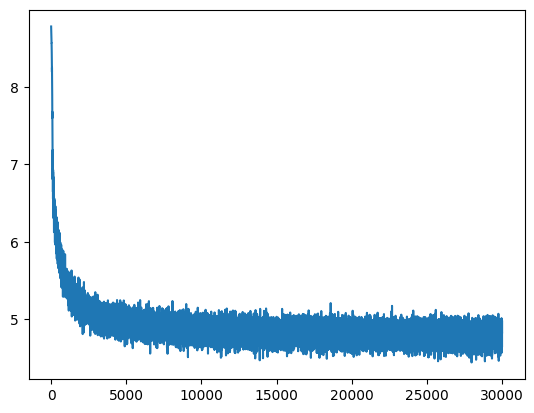

In [9]:
import matplotlib.pyplot as plt
plt.plot(list(range(n_iter)), loss_hist)

In [10]:
minibatch = torch.randint(0,len(X), (1000,))
emb = C[X]
Z1 = emb.view(-1, block*emb_hidden) @ W1 + b1
A1 = Z1.tanh()
logits = A1 @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.535470962524414


In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
from matplotlib.font_manager import FontProperties
import os
font_path = os.path.expanduser('~/../../Library/Fonts/PingFang.ttc')
font_prop = FontProperties(fname=font_path, size=14)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2char[i], ha="center", va="center", color='white',fontproperties=font_prop)
plt.grid('minor')

In [11]:
# sample from the model
g = torch.Generator().manual_seed(1234)

for _ in range(20):
    
    out = [697]
    context = [0] * (block-1) + [697] # initialize with all ... 
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      out.append(ix)
      context = context[1:] + [ix]
      
      if ix == 0:
        break
    
    print(''.join(idx2char[i] for i in out))

周雨蹋.
周素哲.
周业尺.
周宣.
周铭雪.
周漫媛.
周卿.
周香豆.
周俊桐.
周玥煊.
周凯芮.
周婷馨.
周雨凡.
周立喆.
周霞.
周涵婷.
周昃佩.
周业.
周思富.
周家纯.


In [26]:
char2idx['陆']

6033